In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import sklearn
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

data_path = "data\Snow_Trends_Data\First-Snow-Dates"
stations_filepath = "data\Snow_Trends_Data\stations.csv"
states_shapefile_path = r"data\shapefile-data\usa-states-census-2014.shp"

In [16]:
for root, directories, files in os.walk(data_path):
    filepaths_list = [root + "\\" + file for file in files if file[:3].isnumeric()]
originaldf = pd.DataFrame()
for file in filepaths_list:
    with open(file, "r") as inputcsv:
        print("Reading",file)
        season_year = file[-8:-4]
        df = pd.read_csv(inputcsv)
        df["date"] = pd.to_datetime(df.date, format="%Y-%m-%d")
        df["season_year"] = int(season_year)
        originaldf = pd.concat([originaldf, df], ignore_index=True)


#extract lat and lon using the stations file
with open(stations_filepath, "r") as stationsfile:
    stationsdf = pd.read_csv(stationsfile)
#join dataframes on the id column
originaldf = originaldf.join(stationsdf.set_index("id"), on="id")[["latitude", "longitude", "elevation","date", "season_year"]]
originaldf.dropna(inplace=True)


#We'll convert the date to be the number of days since Sep 1st
def convert_datetime(dataframe_row, reference_month=9):
    '''
    Given a row from the masterdf dataframe, return the number of days as an integer
     relative to the given epoch date.
    '''
    try:
        date = dataframe_row[0]
        season_year = dataframe_row[1]
        delta = date - datetime.datetime(season_year, reference_month, 1)
        if delta.days < 0:
            return 0
        else:
            return delta.days
    except Exception as e:
        print("Error in converting date to integer days:",e)
        return None
masterdf = originaldf.copy()
masterdf["days"] = masterdf[["date", "season_year"]].apply(convert_datetime, axis=1)

# Write output to csv.gz
masterdf.to_csv(r"data\first-snow-dates-per-station_1980-2020.csv.gz", compression="gzip", index=False)
masterdf.sample(5)

Reading data\Snow_Trends_Data\First-Snow-Dates\1980.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1981.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1982.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1983.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1984.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1985.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1986.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1987.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1988.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1989.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1990.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1991.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1992.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1993.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1994.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1995.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1996.csv
Reading data\Snow_Trends_Data\First-Snow-Dates\1

,latitude,longitude,elevation,date,season_year,days
94505,42.815360,-108.726040,1698.5,1997-10-25,1997,54
292955,41.569700,-115.211100,1816.6,2018-11-23,2018,83
287118,35.977313,-78.708743,126.2,2018-12-09,2018,99
242213,42.762100,-84.761700,244.1,2014-11-14,2014,74
303112,43.968559,-104.241676,1502.4,2019-10-10,2019,39


In [21]:
print(len(masterdf))
masterdf.dtypes

317872


latitude              float64
longitude             float64
elevation             float64
date           datetime64[ns]
season_year             int64
days                    int64
dtype: object

Let's plot ALL points on the same scatterplot, heatmapped by their first snow day

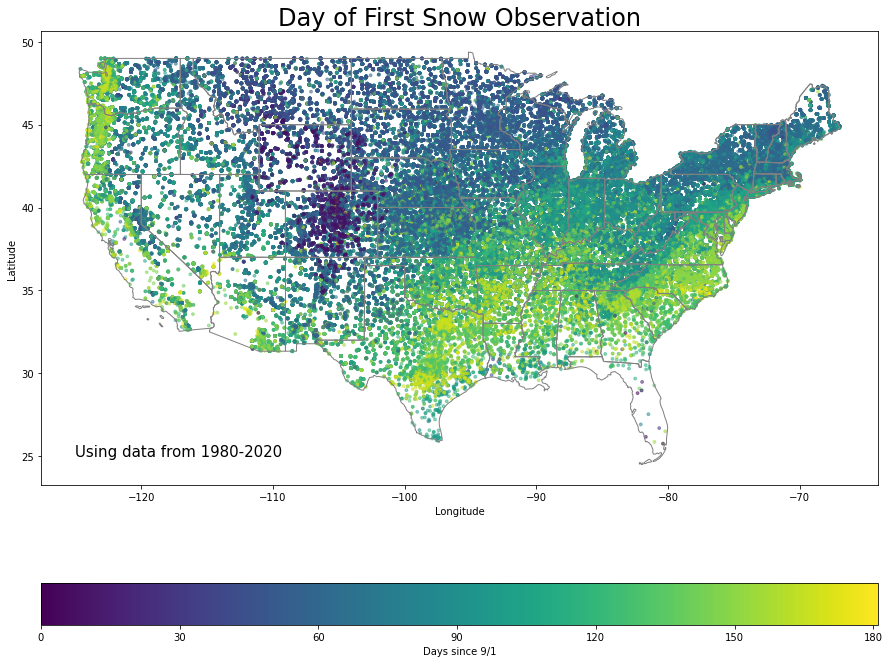

In [41]:
#Read the geopandas shape file for continental US states
states = gpd.read_file(states_shapefile_path)

def generate_geodataframe(input_df):    
    '''
    Given an input dataframe with `latitude`, `longitude`, `elevation`,
        `date` of first snow observed at that site (YYYY-MM-DD), the winter season
        year `year`, and `days` (integer days between `date` and September 1st of that winter),
    Generate a Geodataframe consisting of 2D point geometries. Elevation is not used, but provided
        for future work.
    '''
    #defined coordinate reference system. Use the same as the states shapefile.
    crs='epsg:4326'
    #define a geometry consisting of Points, to use as the GDF geometry
    geometry=[Point(longlat_tuple) for longlat_tuple in zip(input_df['longitude'], input_df['latitude'])]
    #create the GDF using the data and the geometry
    geoDF = gpd.GeoDataFrame(input_df[['date', 'season_year', "days"]], crs=crs, geometry=geometry)
    return geoDF

def points_per_day(input_df, month=None, day=1, reference_month=9, crs="epsg:4326"):
    ''' 
    Provide an dataframe (to the specifications 
        of `generate_geodataframe`, target month, and optional day, and
    Return a geodataframe of all sites whose first snow day occurs before that day of the season.
        Assumes a Sep 1st start.
        If month is not provided, all data is used
    '''
    if month is None:
        selected_data = input_df
    elif month < reference_month:
        #Account for the new year if the target month occurs before the reference month 
        selected_data = input_df[input_df.date < pd.to_datetime({"year":input_df.season_year + 1, "month":month, "day":day})]
    else:
        selected_data = input_df[input_df.date < pd.to_datetime({"year":input_df.season_year, "month":month, "day":day})]
    #print(selected_data)
    geometry=[Point(longlat_tuple) for longlat_tuple in zip(selected_data['longitude'], selected_data['latitude'])]
    selectGeoDF = gpd.GeoDataFrame(selected_data[['date', 'season_year', "days"]], crs=crs, geometry=geometry)
    return selectGeoDF

def convert_days_to_date(days, reference_month=9, reference_day=1):
    """
    Given an integer `days` value, assumed to be the number of days since September 1st (ignore leap years),
    Calculate the month and day associated with that difference.
    Return a pandas datetime object
    """
    #Let's use an arbitrary, non-leap reference year
    reference_year = 2022
    delta = datetime.timedelta(days=days)
    reference = datetime.datetime(reference_year, reference_month, reference_day)
    full_date = reference + delta
    return full_date

def generate_map(input_df, month=None, day=1, reference_month=9, crs="epsg:4326"):
    """
    Generate a heatmap of points 
    """
    pointMap = points_per_day(input_df, month=month, day=day, reference_month=reference_month, crs=crs)
    continentalUS = states.boundary.plot(figsize=(15,12), color='grey', linewidth=1)
    earliest_year = pointMap.season_year.min()
    latest_year = pointMap.season_year.max()
    if month:
        title_text = f"Stations Having Observed Snow prior to {month}/{day}"
    else:
        title_text = "Day of First Snow Observation"
    plt.title(title_text, fontsize=24)
    plt.text(-125, 25, f"Using data from {earliest_year}-{latest_year}", fontsize=15)
    pointMap["month_days_date"] = pointMap["days"].apply(convert_days_to_date)
    pointMap.plot(ax=continentalUS, markersize=8, column=pointMap.days,\
                  cmap="viridis", alpha = 0.5, legend=True,\
                  legend_kwds={"label": f"Days since {reference_month}/1", \
                               "orientation": "horizontal",
                              "ticks":[i*30 for i in range(0,360) if i < pointMap.days.max()]})
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    

generate_map(masterdf)#, 1, 14, reference_month=9)

 Now let's use a K-Nearest Neighbors regression model to predict the integer day of first snow based on latitude and longistude

In [12]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = masterdf[["longitude", "latitude"]]
print(len(X))
y = masterdf.days

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state = 0)

neighbors = 40
knn_reg = KNeighborsRegressor(n_neighbors = neighbors).fit(X_train, y_train)
score = knn_reg.score(X_test, y_test)
print("R-squared score with {} neighbors: {}".format(neighbors, score))

317872
R-squared score with 40 neighbors: 0.4541980303666745


In [13]:
def create_point_gdf(lon_array, lat_array, crs="epsg:4326"):
    coord_list = []
    for lon in lon_array:
        for lat in lat_array:
            coord_list.append((lon, lat))
    geom = [Point(lonlat_tuple) for lonlat_tuple in coord_list]
    gdf = gpd.GeoDataFrame(coord_list, columns=["longitude", "latitude"], crs=crs, geometry=geom)
    return gdf

lon_arr = np.linspace(-130, -60, 1000)
lat_arr = np.linspace(22, 50, 1000)
uniform_points = create_point_gdf(lon_arr, lat_arr)
clipped_points = gpd.clip(uniform_points, states).reset_index(drop=True)


In [8]:
X_scaled = scaler.fit_transform(clipped_points[["longitude", "latitude"]])
y_predict = knn_reg.predict(X_scaled)
output_clipped_points = clipped_points.copy()
output_clipped_points["days"] = y_predict
output_clipped_points

,longitude,latitude,geometry,days
0,-124.674675,47.981982,POINT (-124.67467 47.98198),112.725
1,-124.674675,48.010010,POINT (-124.67467 48.01001),113.350
2,-124.674675,48.038038,POINT (-124.67467 48.03804),113.825
3,-124.674675,48.066066,POINT (-124.67467 48.06607),115.425
4,-124.674675,48.094094,POINT (-124.67467 48.09409),115.425
...,...,...,...,...
419165,-67.007007,44.786787,POINT (-67.00701 44.78679),90.750
419166,-67.007007,44.814815,POINT (-67.00701 44.81481),90.750
419167,-67.007007,44.842843,POINT (-67.00701 44.84284),90.750
419168,-67.007007,44.870871,POINT (-67.00701 44.87087),90.750


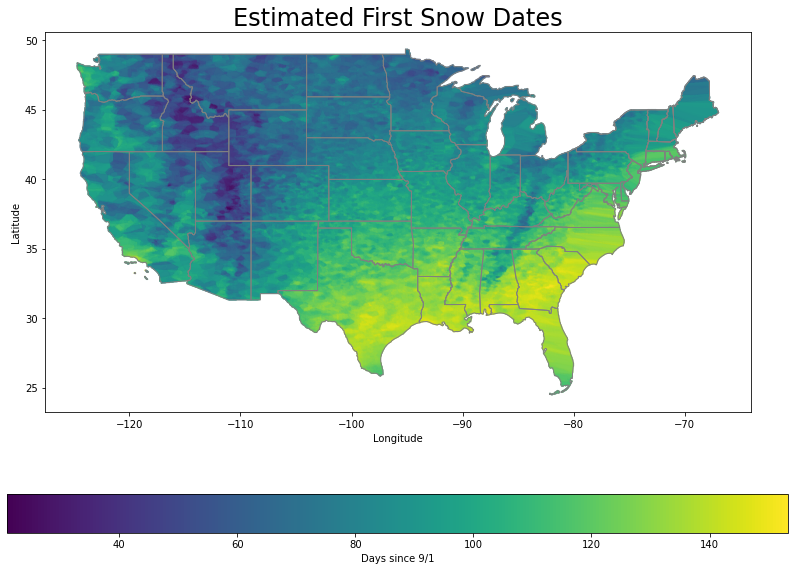

In [9]:
continentalUS = states.boundary.plot(figsize=(14,10), color='grey', linewidth=1)
plt.title("Estimated First Snow Dates", fontsize=24)
#plt.text(-125, 25, f"Using data from {earliest_year}-{latest_year}", fontsize=15)
output_clipped_points.plot(ax=continentalUS, markersize=0.5, column=output_clipped_points.days,\
                cmap="viridis", alpha = 0.5, legend=True,\
                legend_kwds={"label": f"Days since 9/1", \
                               "orientation": "horizontal"})
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
    

In [ ]:
"""
TO-DO
Write Function to map days back into a month-date pair
Convert colorbar to month-date
Overlay comparison points, or write a widget to gradually build on points with a slider


Find larger datasets, and compare how the layers change over 5-year periods.

"""